## Image Captioning - Transformer

In [1]:
import os
from pathlib import Path
#import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
#from PIL import Image
from collections import Counter
import sys
import random
from nltk.translate.bleu_score import sentence_bleu

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split

#Vision
import torchvision.transforms as T
#import torchvision.models as models

#Torchtext
#import torchtext; torchtext.disable_torchtext_deprecation_warning() #supress warning
from torchtext.vocab import vocab
#from torchtext.data.utils import get_tokenizer


import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SH2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

For reproducibility:

In [2]:
def set_seed(seed):
    random.seed(seed)  #Python random module
    np.random.seed(seed)  #NumPy random module
    torch.manual_seed(seed)  #PyTorch CPU
    torch.cuda.manual_seed(seed)  #PyTorch GPU
    torch.cuda.manual_seed_all(seed)  #Multi-GPU setups
    torch.backends.cudnn.deterministic = True  #Deterministic behavior
    torch.backends.cudnn.benchmark = False  #Reproducibility

set_seed(46)

In [3]:
#Run if needed
# with zipfile.ZipFile('data/archive.zip') as z_temp:
#     z_temp.extractall(path='data/')

Check path to the image files and caption file:

In [4]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
single_captions_path = project_root / 'data' / 'flickr30k_images' / 'single_captions_results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [5]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

image_name comment_number  \
68478   3382777250.jpg              3   
11402    170525554.jpg              2   
138363  5812770731.jpg              3   
27114   2385034500.jpg              4   
65696   3328380165.jpg              1   
145877  6839984356.jpg              2   
100312  4467634558.jpg              2   

                                                  comment  
68478    A child in a striped shirt is standing in fro...  
11402    A man in black shirt is taking pictures in a ...  
138363   A young female baseball player slides to home...  
27114              Bikers ride down a busy rural street .  
65696    A man in sunglasses is sitting on top of a pl...  
145877   A youth wearing yellow sits on a wall holding...  
100312   Three children pose for a photograph by a rock .

In [6]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [7]:
from src.vocab_builder import VocabularyBuilder

#Replace non-string values with empty string
image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

if Path.cwd().name == 'notebooks':
    os.chdir("..")

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab_full.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [8]:
words = vocab.get_itos()
#print("Words in our vocab:", words)

vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Total number of words in vocab: 12102


Creating our dataset instance:

In [9]:
from src.image_caption_dataset import ImageCaptionDataset

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transforms = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


flickr_dataset =  ImageCaptionDataset(
    image_paths = image_paths,
    captions = captions_path,
    vocabulary_builder=vocab_builder,
    transform = transforms
)

In [10]:
# all_tokens = []
# max_caption_len = 0

# for caption in flickr_dataset.captions:
#     tokens = vocab_builder.spacy_tokenizer(caption)
#     all_tokens.extend(tokens)
#     max_caption_len = max(max_caption_len, len(tokens))

# print("Most common tokens in dataset:")
# print(Counter(all_tokens).most_common(10))
# print(f"Maximum caption length in dataset: {max_caption_len}")

# Most common tokens in dataset:
# [('a', 71335), ('in', 24736), ('the', 19866), ('and', 17928), ('with', 13099), ('on', 12532), ('of', 12311), ('is', 11760), ('man', 9933), ('wearing', 6428)]
# Maximum caption length in dataset: 78
max_sentence_length = 78


Normalized Image:


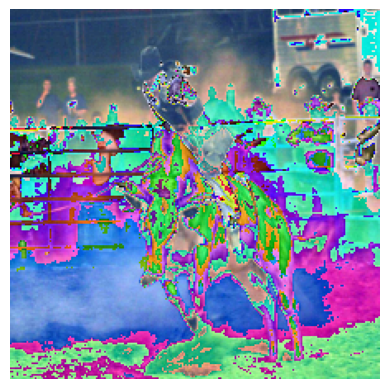

Denormalized Image:


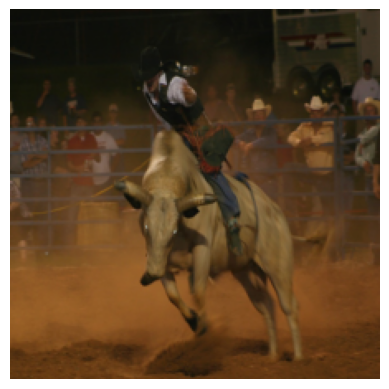

tensor([   2,   31,   32,   70,  911,  860,   50,   18, 5429,  778,   70,  527,
         710,   31, 3697,    3])
Caption :
<sos> a man is being thrown from the bull he is riding during a rodeo <eos>


In [11]:
from src.utils import display_image

img, ids, cap_text = flickr_dataset[10366]
print("Normalized Image:")
display_image(img, denormalize=False)
print("Denormalized Image:")
display_image(img, denormalize=True, mean=mean, std=std)
print(ids)
print('Caption :')
print(vocab_builder.token_ids_to_caption(ids))

Defining dataloader for our dataset and also split dataset into train and test sets (80% train, 20% test)

In [12]:
train_size = int(0.91 * len(flickr_dataset))
val_size = int(0.045 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    flickr_dataset, [train_size, val_size, test_size]
)

In [13]:
print(f"Number of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")
print(f"Number of test samples: {test_size}")


Number of training samples: 144611
Number of validation samples: 7151
Number of test samples: 7152


## Transformer

In [14]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 192
num_workers = 4
prefetch_factor = 2

collator = BatchCaptionCollator(pad_idx=pad_idx, max_len=max_sentence_length, batch_first=True)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

In [15]:
vocab_size = len(vocab_builder.vocabulary)

enc_hidden_size = None #For class compatibility
attn_size = None #For class compatibility

emb_size = 300
drop_prob = 0.3
dec_hidden_size = 1024
num_heads=4
num_layers=6
ff_dim=2048
max_len=max_sentence_length + 5

learning_rate = 1e-4
num_epochs = 100
print_every = 600

weight_decay = 1e-5

backbone="resnet50"
#backbone="efficientnet"
transformation="conv2d"

save_dir = "saved_model"


In [16]:
from src.models.encoderdecoder import EncoderDecoder

model_transformer = EncoderDecoder(
    emb_size=emb_size,
    vocab_size=vocab_size,
    attn_size=attn_size,
    enc_hidden_size=enc_hidden_size,
    dec_hidden_size=dec_hidden_size,
    drop_prob=drop_prob,
    device=device,
    decoder_type='transformer', 
    num_heads=num_heads, 
    num_layers=num_layers, 
    ff_dim=ff_dim, 
    max_len=max_len,
    backbone=backbone,
    transformation=transformation
).to(device)


criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'], label_smoothing=0.2)
optimizer = optim.Adam(model_transformer.parameters(), lr = learning_rate, weight_decay=weight_decay)


In [17]:
from src.utils import EarlyStopping

earlystopping_patience = 4

LR_patience = 2
LR_factor = 0.1


early_stopping = EarlyStopping(patience=earlystopping_patience, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_factor, patience=LR_patience, verbose=True)

Epoch: 1, Batch: 600, Training Loss: 5.23468


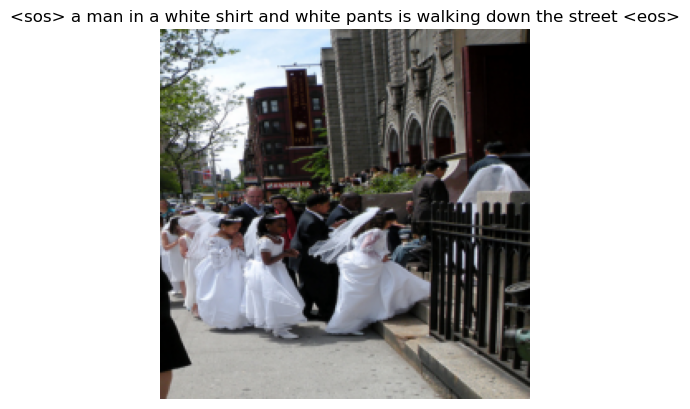

Epoch 1/100 - Train Loss: 5.4849, Val Loss: 5.0528, BLEU: 0.0526, ROUGE-1 Precision: 0.2981, ROUGE-1 Recall: 0.3246, ROUGE-1 F1: 0.2963, ROUGE-2 Precision: 0.0916, ROUGE-2 Recall: 0.0985, ROUGE-2 F1: 0.0901, ROUGE-L Precision: 0.2701, ROUGE-L Recall: 0.2973, ROUGE-L F1: 0.2699
Saved checkpoint for epoch 1 at saved_model\Transformer_resnet50_conv2d_epoch_1.pth.gz
Epoch: 2, Batch: 600, Training Loss: 4.99723


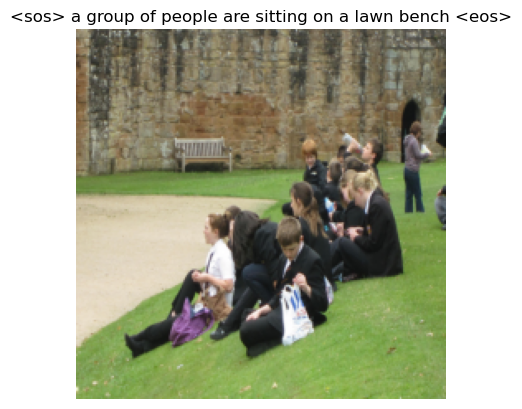

Epoch 2/100 - Train Loss: 4.9422, Val Loss: 4.8550, BLEU: 0.0609, ROUGE-1 Precision: 0.3138, ROUGE-1 Recall: 0.3401, ROUGE-1 F1: 0.3115, ROUGE-2 Precision: 0.1023, ROUGE-2 Recall: 0.1104, ROUGE-2 F1: 0.1010, ROUGE-L Precision: 0.2853, ROUGE-L Recall: 0.3122, ROUGE-L F1: 0.2845
Saved checkpoint for epoch 2 at saved_model\Transformer_resnet50_conv2d_epoch_2.pth.gz
Epoch: 3, Batch: 600, Training Loss: 4.76809


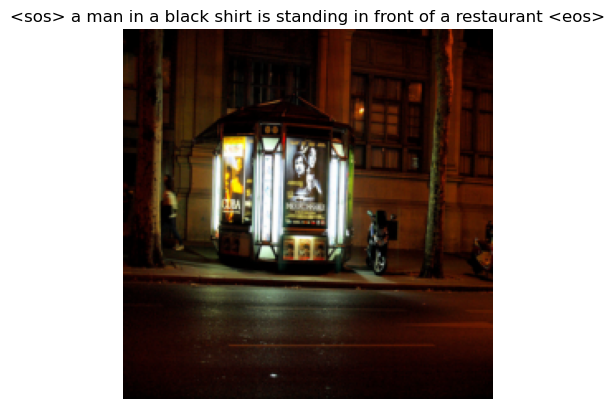

Epoch 3/100 - Train Loss: 4.7759, Val Loss: 4.7573, BLEU: 0.0595, ROUGE-1 Precision: 0.3069, ROUGE-1 Recall: 0.3537, ROUGE-1 F1: 0.3132, ROUGE-2 Precision: 0.1020, ROUGE-2 Recall: 0.1183, ROUGE-2 F1: 0.1040, ROUGE-L Precision: 0.2777, ROUGE-L Recall: 0.3233, ROUGE-L F1: 0.2847
Saved checkpoint for epoch 3 at saved_model\Transformer_resnet50_conv2d_epoch_3.pth.gz
Epoch: 4, Batch: 600, Training Loss: 4.68780


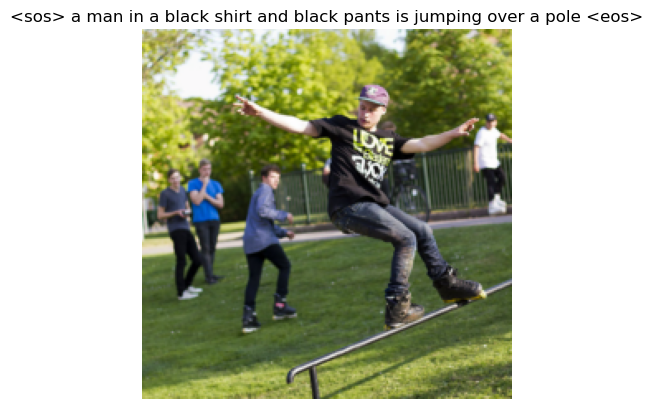

Epoch 4/100 - Train Loss: 4.6664, Val Loss: 4.7052, BLEU: 0.0653, ROUGE-1 Precision: 0.3232, ROUGE-1 Recall: 0.3560, ROUGE-1 F1: 0.3230, ROUGE-2 Precision: 0.1088, ROUGE-2 Recall: 0.1200, ROUGE-2 F1: 0.1083, ROUGE-L Precision: 0.2934, ROUGE-L Recall: 0.3258, ROUGE-L F1: 0.2943
Saved checkpoint for epoch 4 at saved_model\Transformer_resnet50_conv2d_epoch_4.pth.gz
Epoch: 5, Batch: 600, Training Loss: 4.53498


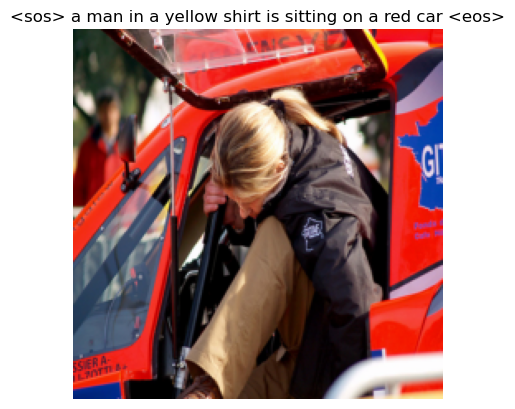

Epoch 5/100 - Train Loss: 4.5805, Val Loss: 4.6544, BLEU: 0.0723, ROUGE-1 Precision: 0.3454, ROUGE-1 Recall: 0.3511, ROUGE-1 F1: 0.3331, ROUGE-2 Precision: 0.1190, ROUGE-2 Recall: 0.1207, ROUGE-2 F1: 0.1142, ROUGE-L Precision: 0.3150, ROUGE-L Recall: 0.3227, ROUGE-L F1: 0.3049
Saved checkpoint for epoch 5 at saved_model\Transformer_resnet50_conv2d_epoch_5.pth.gz
Epoch: 6, Batch: 600, Training Loss: 4.47659


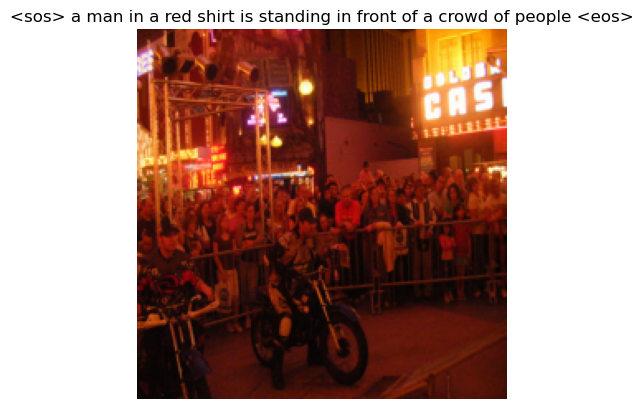

Epoch 6/100 - Train Loss: 4.5083, Val Loss: 4.6226, BLEU: 0.0697, ROUGE-1 Precision: 0.3333, ROUGE-1 Recall: 0.3676, ROUGE-1 F1: 0.3339, ROUGE-2 Precision: 0.1168, ROUGE-2 Recall: 0.1283, ROUGE-2 F1: 0.1162, ROUGE-L Precision: 0.3023, ROUGE-L Recall: 0.3361, ROUGE-L F1: 0.3040
Saved checkpoint for epoch 6 at saved_model\Transformer_resnet50_conv2d_epoch_6.pth.gz
Epoch: 7, Batch: 600, Training Loss: 4.49887


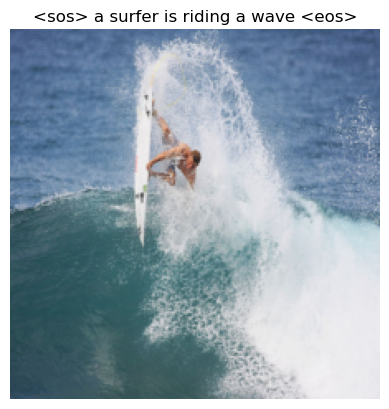

Epoch 7/100 - Train Loss: 4.4438, Val Loss: 4.6067, BLEU: 0.0750, ROUGE-1 Precision: 0.3451, ROUGE-1 Recall: 0.3746, ROUGE-1 F1: 0.3430, ROUGE-2 Precision: 0.1243, ROUGE-2 Recall: 0.1351, ROUGE-2 F1: 0.1231, ROUGE-L Precision: 0.3135, ROUGE-L Recall: 0.3432, ROUGE-L F1: 0.3129
Saved checkpoint for epoch 7 at saved_model\Transformer_resnet50_conv2d_epoch_7.pth.gz
Epoch: 8, Batch: 600, Training Loss: 4.40069


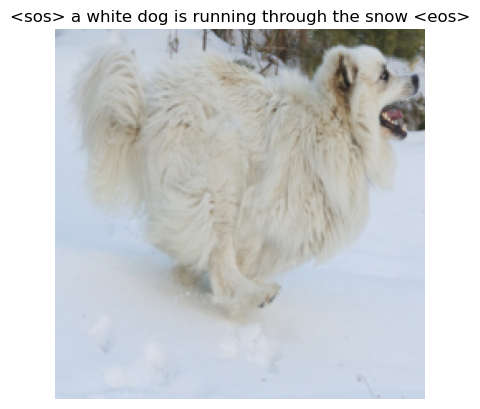

Epoch 8/100 - Train Loss: 4.3872, Val Loss: 4.5850, BLEU: 0.0797, ROUGE-1 Precision: 0.3600, ROUGE-1 Recall: 0.3682, ROUGE-1 F1: 0.3482, ROUGE-2 Precision: 0.1301, ROUGE-2 Recall: 0.1328, ROUGE-2 F1: 0.1252, ROUGE-L Precision: 0.3277, ROUGE-L Recall: 0.3377, ROUGE-L F1: 0.3181
Saved checkpoint for epoch 8 at saved_model\Transformer_resnet50_conv2d_epoch_8.pth.gz
Epoch: 9, Batch: 600, Training Loss: 4.35535


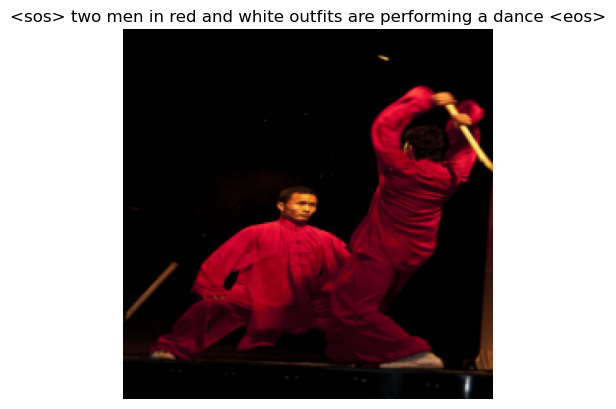

Epoch 9/100 - Train Loss: 4.3337, Val Loss: 4.5735, BLEU: 0.0777, ROUGE-1 Precision: 0.3523, ROUGE-1 Recall: 0.3856, ROUGE-1 F1: 0.3522, ROUGE-2 Precision: 0.1298, ROUGE-2 Recall: 0.1428, ROUGE-2 F1: 0.1296, ROUGE-L Precision: 0.3202, ROUGE-L Recall: 0.3536, ROUGE-L F1: 0.3215
Saved checkpoint for epoch 9 at saved_model\Transformer_resnet50_conv2d_epoch_9.pth.gz
Epoch: 10, Batch: 600, Training Loss: 4.36493


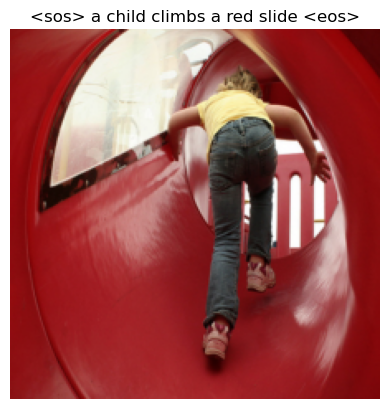

Epoch 10/100 - Train Loss: 4.2851, Val Loss: 4.5635, BLEU: 0.0828, ROUGE-1 Precision: 0.3639, ROUGE-1 Recall: 0.3848, ROUGE-1 F1: 0.3581, ROUGE-2 Precision: 0.1359, ROUGE-2 Recall: 0.1431, ROUGE-2 F1: 0.1330, ROUGE-L Precision: 0.3317, ROUGE-L Recall: 0.3536, ROUGE-L F1: 0.3277
Saved checkpoint for epoch 10 at saved_model\Transformer_resnet50_conv2d_epoch_10.pth.gz
Epoch: 11, Batch: 600, Training Loss: 4.22196


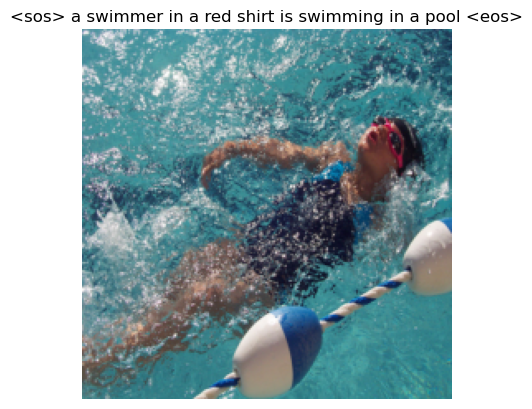

Epoch 11/100 - Train Loss: 4.2402, Val Loss: 4.5583, BLEU: 0.0845, ROUGE-1 Precision: 0.3719, ROUGE-1 Recall: 0.3909, ROUGE-1 F1: 0.3643, ROUGE-2 Precision: 0.1407, ROUGE-2 Recall: 0.1483, ROUGE-2 F1: 0.1375, ROUGE-L Precision: 0.3396, ROUGE-L Recall: 0.3597, ROUGE-L F1: 0.3339
Saved checkpoint for epoch 11 at saved_model\Transformer_resnet50_conv2d_epoch_11.pth.gz
Epoch: 12, Batch: 600, Training Loss: 4.21420


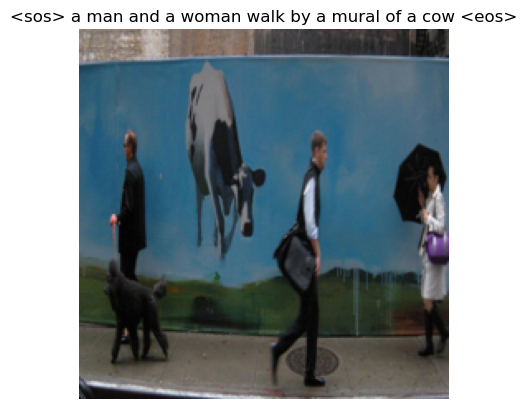

Epoch 12/100 - Train Loss: 4.1973, Val Loss: 4.5491, BLEU: 0.0846, ROUGE-1 Precision: 0.3686, ROUGE-1 Recall: 0.3962, ROUGE-1 F1: 0.3651, ROUGE-2 Precision: 0.1395, ROUGE-2 Recall: 0.1509, ROUGE-2 F1: 0.1381, ROUGE-L Precision: 0.3350, ROUGE-L Recall: 0.3632, ROUGE-L F1: 0.3332
Saved checkpoint for epoch 12 at saved_model\Transformer_resnet50_conv2d_epoch_12.pth.gz
Epoch: 13, Batch: 600, Training Loss: 4.12481


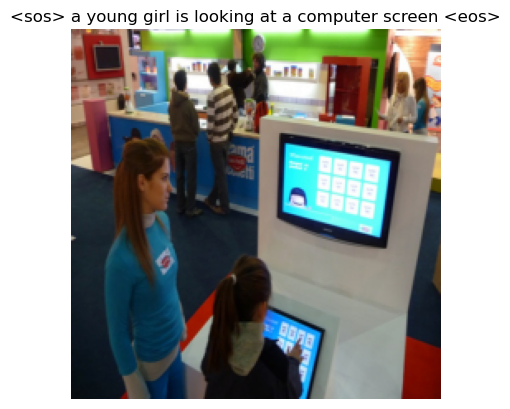

Epoch 13/100 - Train Loss: 4.1584, Val Loss: 4.5398, BLEU: 0.0870, ROUGE-1 Precision: 0.3774, ROUGE-1 Recall: 0.3910, ROUGE-1 F1: 0.3673, ROUGE-2 Precision: 0.1435, ROUGE-2 Recall: 0.1498, ROUGE-2 F1: 0.1398, ROUGE-L Precision: 0.3450, ROUGE-L Recall: 0.3600, ROUGE-L F1: 0.3370
Saved checkpoint for epoch 13 at saved_model\Transformer_resnet50_conv2d_epoch_13.pth.gz
Epoch: 14, Batch: 600, Training Loss: 4.19386


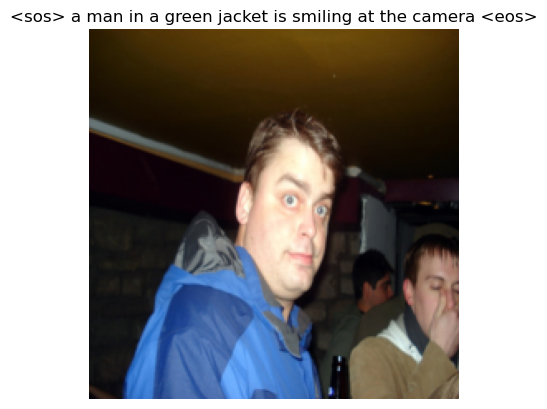

Epoch 14/100 - Train Loss: 4.1198, Val Loss: 4.5443, BLEU: 0.0921, ROUGE-1 Precision: 0.3883, ROUGE-1 Recall: 0.3920, ROUGE-1 F1: 0.3735, ROUGE-2 Precision: 0.1505, ROUGE-2 Recall: 0.1523, ROUGE-2 F1: 0.1445, ROUGE-L Precision: 0.3549, ROUGE-L Recall: 0.3609, ROUGE-L F1: 0.3426
Saved checkpoint for epoch 14 at saved_model\Transformer_resnet50_conv2d_epoch_14.pth.gz
Epoch: 15, Batch: 600, Training Loss: 4.10504


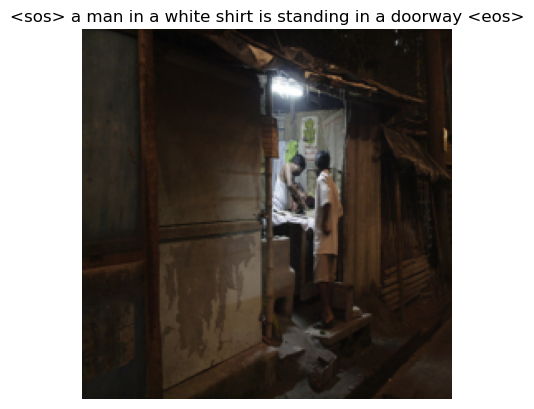

Epoch 15/100 - Train Loss: 4.0840, Val Loss: 4.5455, BLEU: 0.0888, ROUGE-1 Precision: 0.3859, ROUGE-1 Recall: 0.3999, ROUGE-1 F1: 0.3756, ROUGE-2 Precision: 0.1494, ROUGE-2 Recall: 0.1553, ROUGE-2 F1: 0.1451, ROUGE-L Precision: 0.3513, ROUGE-L Recall: 0.3668, ROUGE-L F1: 0.3432
Saved checkpoint for epoch 15 at saved_model\Transformer_resnet50_conv2d_epoch_15.pth.gz
Epoch: 16, Batch: 600, Training Loss: 4.07616


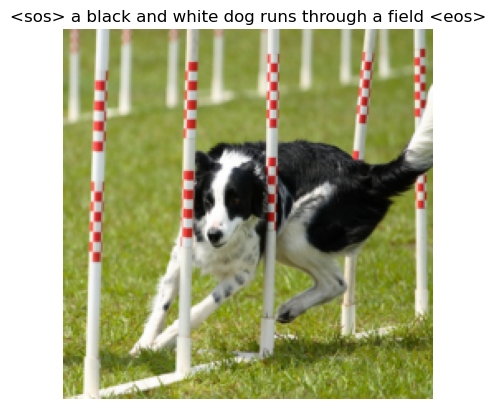

Epoch 16/100 - Train Loss: 4.0512, Val Loss: 4.5477, BLEU: 0.0918, ROUGE-1 Precision: 0.3863, ROUGE-1 Recall: 0.3986, ROUGE-1 F1: 0.3752, ROUGE-2 Precision: 0.1507, ROUGE-2 Recall: 0.1560, ROUGE-2 F1: 0.1461, ROUGE-L Precision: 0.3526, ROUGE-L Recall: 0.3665, ROUGE-L F1: 0.3438
Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.
Saved checkpoint for epoch 16 at saved_model\Transformer_resnet50_conv2d_epoch_16.pth.gz
Epoch: 17, Batch: 600, Training Loss: 3.97491


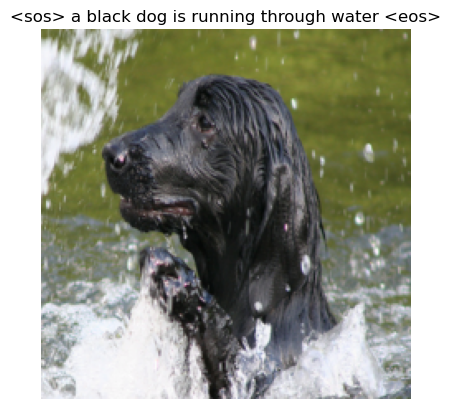

Epoch 17/100 - Train Loss: 3.9399, Val Loss: 4.5300, BLEU: 0.0937, ROUGE-1 Precision: 0.3937, ROUGE-1 Recall: 0.4076, ROUGE-1 F1: 0.3833, ROUGE-2 Precision: 0.1553, ROUGE-2 Recall: 0.1613, ROUGE-2 F1: 0.1510, ROUGE-L Precision: 0.3588, ROUGE-L Recall: 0.3736, ROUGE-L F1: 0.3503
Saved checkpoint for epoch 17 at saved_model\Transformer_resnet50_conv2d_epoch_17.pth.gz
Epoch: 18, Batch: 600, Training Loss: 3.96670


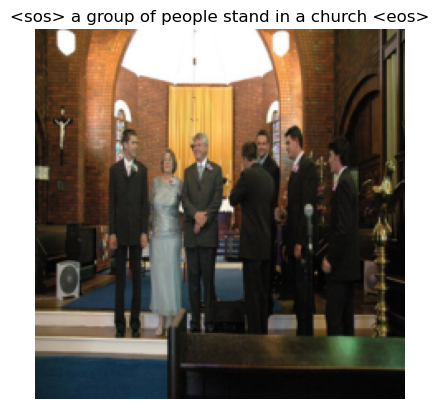

Epoch 18/100 - Train Loss: 3.9181, Val Loss: 4.5298, BLEU: 0.0943, ROUGE-1 Precision: 0.3942, ROUGE-1 Recall: 0.4102, ROUGE-1 F1: 0.3849, ROUGE-2 Precision: 0.1564, ROUGE-2 Recall: 0.1635, ROUGE-2 F1: 0.1526, ROUGE-L Precision: 0.3588, ROUGE-L Recall: 0.3756, ROUGE-L F1: 0.3514
Saved checkpoint for epoch 18 at saved_model\Transformer_resnet50_conv2d_epoch_18.pth.gz
Epoch: 19, Batch: 600, Training Loss: 3.88536


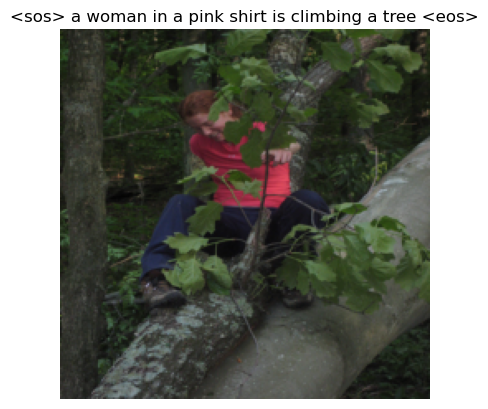

Epoch 19/100 - Train Loss: 3.9051, Val Loss: 4.5304, BLEU: 0.0954, ROUGE-1 Precision: 0.3958, ROUGE-1 Recall: 0.4109, ROUGE-1 F1: 0.3859, ROUGE-2 Precision: 0.1577, ROUGE-2 Recall: 0.1639, ROUGE-2 F1: 0.1534, ROUGE-L Precision: 0.3603, ROUGE-L Recall: 0.3764, ROUGE-L F1: 0.3525
Saved checkpoint for epoch 19 at saved_model\Transformer_resnet50_conv2d_epoch_19.pth.gz
Epoch: 20, Batch: 600, Training Loss: 3.92679


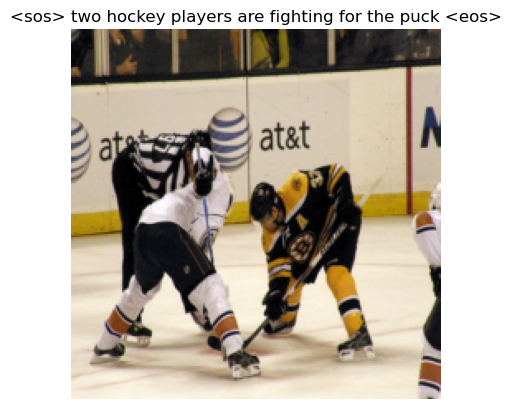

Epoch 20/100 - Train Loss: 3.8951, Val Loss: 4.5309, BLEU: 0.0953, ROUGE-1 Precision: 0.3966, ROUGE-1 Recall: 0.4097, ROUGE-1 F1: 0.3857, ROUGE-2 Precision: 0.1576, ROUGE-2 Recall: 0.1634, ROUGE-2 F1: 0.1529, ROUGE-L Precision: 0.3613, ROUGE-L Recall: 0.3756, ROUGE-L F1: 0.3524
Epoch 00020: reducing learning rate of group 0 to 1.0000e-06.
Saved checkpoint for epoch 20 at saved_model\Transformer_resnet50_conv2d_epoch_20.pth.gz
Epoch: 21, Batch: 600, Training Loss: 3.94301


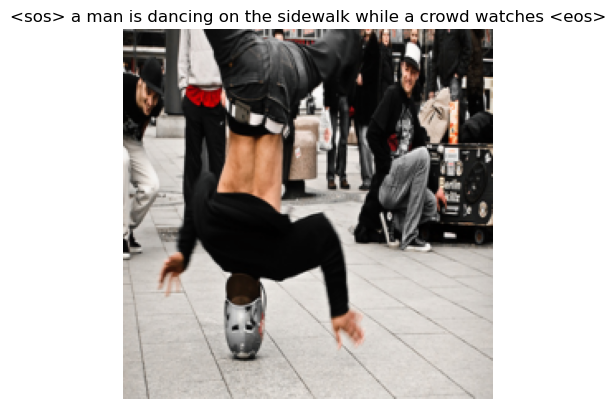

Epoch 21/100 - Train Loss: 3.8794, Val Loss: 4.5314, BLEU: 0.0948, ROUGE-1 Precision: 0.3946, ROUGE-1 Recall: 0.4099, ROUGE-1 F1: 0.3848, ROUGE-2 Precision: 0.1567, ROUGE-2 Recall: 0.1636, ROUGE-2 F1: 0.1527, ROUGE-L Precision: 0.3593, ROUGE-L Recall: 0.3756, ROUGE-L F1: 0.3515
Saved checkpoint for epoch 21 at saved_model\Transformer_resnet50_conv2d_epoch_21.pth.gz
Epoch: 22, Batch: 600, Training Loss: 3.93946


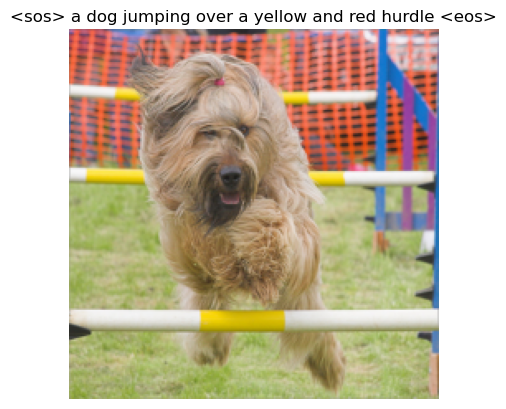

Epoch 22/100 - Train Loss: 3.8778, Val Loss: 4.5303, BLEU: 0.0952, ROUGE-1 Precision: 0.3972, ROUGE-1 Recall: 0.4112, ROUGE-1 F1: 0.3867, ROUGE-2 Precision: 0.1574, ROUGE-2 Recall: 0.1636, ROUGE-2 F1: 0.1530, ROUGE-L Precision: 0.3614, ROUGE-L Recall: 0.3764, ROUGE-L F1: 0.3529
Early stopping triggered after epoch 22
Evaluating on the test set...
Test Results - Loss: 4.5182, BLEU: 0.0970, ROUGE-1 F1: 0.3856, ROUGE-2 F1: 0.1545, ROUGE-L F1: 0.3533, 


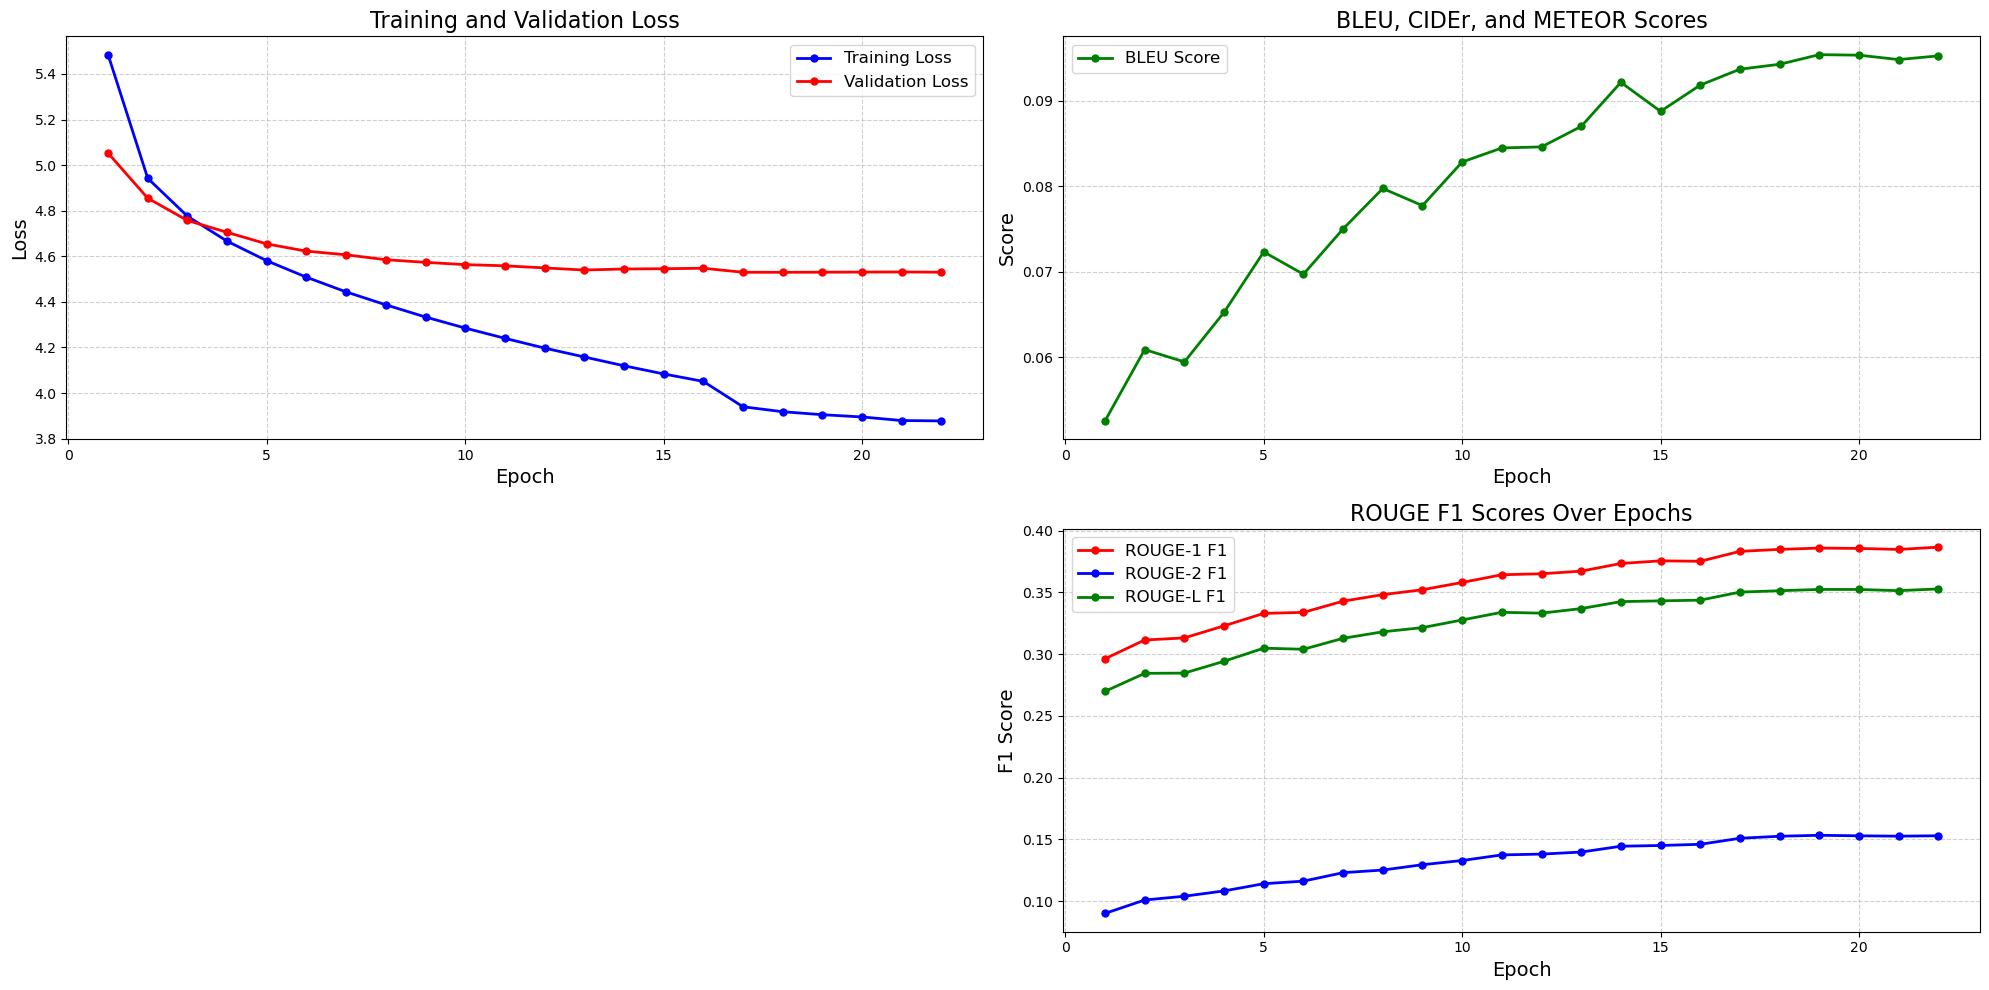

In [18]:
from src.utils import train_model

train_model(
    model=model_transformer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    vocab=vocab,
    vocab_builder=vocab_builder,
    num_epochs=num_epochs,
    print_every=print_every,
    early_stopping=early_stopping,
    save_dir=save_dir,
    device=device,
    Transform_mean=mean,
    Transform_std=std,
    model_name="Transformer",
    max_sentence_length=max_len,
    encoder_backbone=backbone,
    transformation_type=transformation
)